<a href="https://colab.research.google.com/github/hyunBBB/OMG/blob/main/04_Keras_API%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNN(MLP) 모델을 이용한 자동차 연비 데이터 셋 회귀 분석

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
print(tf.__version__)

2.8.2


In [ ]:
!nvida_smi


### Step 1-1. Inptu tensor 와 Target tensor 준비(훈련데이터)
* 자동차 연비 데이터셋 파일 down

In [3]:
auto_mpg_dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dataset_path = tf.keras.utils.get_file("/content/auto-mpg.data", auto_mpg_dataset_url)
dataset_path

40960/30286 [========================================] - 0s 1us/step


'/content/auto-mpg.data'

*  데이터 셋 파일을 읽어 Dataframe 객체 생성

In [4]:
# 자동차 연비 데이터 셋의 컬럼명
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=" ", skipinitialspace=True)
# na_value는 쓰레기값. 
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### Step 1-2. 입력 데이터의 전처리 
* 데이터 셋 내의 NaN 값 제거
트루는 1임. 홀수는 0이고 엥 맞나

In [ ]:
# 데이터 셋 내의 Nan 값 체크
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# 데이터 셋 내 의 Nan 값 제거
dataset = dataset.dropna()

In [6]:
len(dataset)

392

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

* 데이터셋 에서 20% 선택하여 test 데이터 셋으로 분할

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

314
78


* 표준화를 통한 Input tensor의 전처리

In [10]:
# 데이터 전처리를 위한 통계정보 생성
train_stats = train_dataset.describe()

In [11]:
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,1.573248
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.800988
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,1.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,2.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,3.000000


In [12]:
# 정답 데이터(MPG-연비) 제거 pop 함수
train_stats.pop('MPG')

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [13]:
train_stats

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,1.573248
std,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.800988
min,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,1.000000
25%,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,1.000000
50%,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000
75%,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,2.000000
max,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,3.000000


In [14]:
# 각 특성 별 통계정보를 가공하기 쉽도록 matrix 전치
train_stats = train_stats.transpose()

In [15]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [16]:
# Target tensor 를 위한 연비 값(MPG - Miles Per Gallon) 추출
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [17]:
train_dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
146,4,90.0,75.0,2125.0,14.5,74,1
282,4,140.0,88.0,2890.0,17.3,79,1
69,8,350.0,160.0,4456.0,13.5,72,1
378,4,105.0,63.0,2125.0,14.7,82,1
331,4,97.0,67.0,2145.0,18.0,80,3
...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1
229,8,400.0,180.0,4220.0,11.1,77,1
150,4,108.0,93.0,2391.0,15.5,74,3
145,4,83.0,61.0,2003.0,19.0,74,3


In [19]:
# Input tensor의 표준화(평균 :0/ 표준편차 :1) 함수 정의
def norm(x):
  normed_data = (x - train_stats['mean']) / train_stats['std'] #표준정규분포를 위한 공식 각 통계값에서 평균 빼고 뭐로 나누면 ㅁ노말라이즈 으앙
  return normed_data

In [20]:
# Input tensor 의 특성 정보 표준화 처리 수행
train_dataset = norm(train_dataset)
test_dataset = norm(test_dataset)

In [21]:
train_dataset.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02,3.140000e+02
mean,1.824443e-16,8.627211e-17,-9.900078e-18,-8.485781e-17,-5.148041e-16,9.772791e-16,-9.617219e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.457657e+00,-1.220325e+00,-1.545283e+00,-1.589352e+00,-2.710152e+00,-1.604642e+00,-7.156763e-01
25%,-8.693480e-01,-8.608943e-01,-7.512407e-01,-8.694784e-01,-6.307245e-01,-7.884578e-01,-7.156763e-01
50%,-8.693480e-01,-4.247848e-01,-2.721905e-01,-1.987817e-01,-2.123729e-02,2.772599e-02,-7.156763e-01
75%,1.483887e+00,6.750739e-01,6.071620e-01,7.320173e-01,5.882500e-01,8.439098e-01,5.327813e-01
max,1.483887e+00,2.489002e+00,3.153347e+00,2.547401e+00,3.313017e+00,1.660094e+00,1.781239e+00


### Step2. DNN(MLP) 모델 디자인

In [22]:
# hidden layer : 2개[64, 32], activation : relu
model = models.Sequential()
model.add(layers.Dense(units=64, activation='relu', input_shape=(len(train_dataset.keys()),)))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


### Step 3. 모델의 학습 정보 설정

In [24]:
# loss : mean square error/ optimizer : rmsprop/ metric : mean absolute error
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

### Step 4. 모델에 input, target 데이터 연결 후 학습

In [25]:
# batch size : 16, epochs : 100, validation data set percent : 20%
history = model.fit(
    x=train_dataset, y=train_labels,
    batch_size=16,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 552.5160 - mae: 22.2641 - val_loss: 540.0272 - val_mae: 21.9704
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 487.1146 - mae: 20.8307 - val_loss: 464.9013 - val_mae: 20.2880
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 408.7766 - mae: 18.9684 - val_loss: 373.6906 - val_mae: 18.0323
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 319.7362 - mae: 16.6156 - val_loss: 277.0497 - val_mae: 15.2769
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 230.5621 - mae: 13.8607 - val_loss: 184.8170 - val_mae: 12.1878
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 150.8194 - mae: 10.8983 - val_loss: 111.3491 - val_mae: 9.2420
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 90.2982 - mae: 8.1035 - val_loss: 62.0384 - val_mae: 6.6536
Epoch 8/100
16/16 [==========================

### 학습과정의 시각화 및 성능 테스트

In [26]:
hist = pd.DataFrame(history.history)
hist

,loss,mae,val_loss,val_mae
0,552.515991,22.264099,540.027161,21.970448
1,487.114563,20.830692,464.901337,20.287962
2,408.776642,18.968447,373.690582,18.032314
3,319.736237,16.615561,277.049683,15.276901
4,230.562057,13.860739,184.817017,12.187799
...,...,...,...,...
95,6.172049,1.722228,9.193311,2.205068
96,6.283567,1.756525,8.782695,2.214121
97,6.184903,1.760696,8.850392,2.289031
98,6.160957,1.736434,9.099210,2.351604


In [27]:
# 학습과정 시각화를 위한 정보 추출
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history['mae']
val_mae = history.history['val_mae']

In [28]:
# 차트의 x 축을 위한 epoch 정보 생성
epochs = range(1, len(loss)+1)

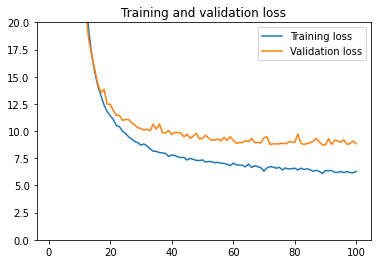

In [29]:
# loss 정보 시각화
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0,20])
plt.legend()

plt.show()

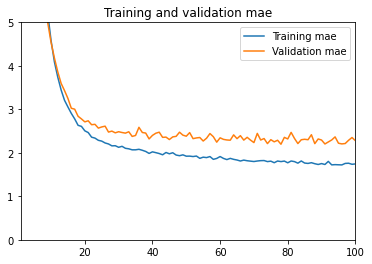

In [30]:
# Mean Absolute Error 정보 시각화
plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.title('Training and validation mae')
plt.xlim([1,100])
plt.ylim([0,5])
plt.legend()

plt.show()

In [31]:
# 테스트 데이터 셋을 통한 성능 측정
test_loss, test_mae = model.evaluate(x=test_dataset, y=test_labels)

3/3 [==============================] - 0s 4ms/step - loss: 7.2134 - mae: 2.0150


In [32]:
# 테스트 데이터 셋의 정답과 모델의 예측값 분석을 위한 모델의 예측값 생성
test_predictions = model.predict(test_dataset).flatten()

In [35]:
len(test_predictions)

78

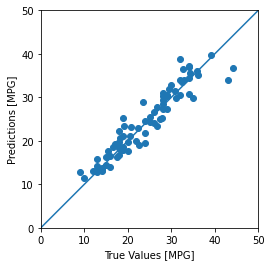

In [33]:
# 테스트 데이터 셋의 정답과 모델의 예측값을 이용한 상관 관계 시각화
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 50])
plt.ylim([0,50])
_ = plt.plot([-100, 100], [-100, 100])